In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !cp -r "/content/drive/MyDrive/Khush_data" "/content/Khush_data"

In [1]:
import zipfile
import os

folder_name = "Khush_data.zip"  # Change this to your actual ZIP file name
with zipfile.ZipFile(folder_name, 'r') as zip_ref:
    zip_ref.extractall("/content")  # Extract in Colab's working directory
os.remove(folder_name)  # Optional: Remove the ZIP file after extraction

In [2]:
train_dir = "/content/Khush_data/Training"
test_dir = "/content/Khush_data/Testing"
val_dir = "/content/Khush_data/Validation"

In [3]:
!pip install -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.5 MB/s eta 0:00:00


In [4]:
import os
import glob
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D, BatchNormalization, GlobalAveragePooling2D
import matplotlib.pyplot as plt
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [5]:
# List class labels (folder names)
class_labels = os.listdir(train_dir)
class_labels.sort()  # Sort to maintain consistent order

print("Classes in the dataset:", class_labels)

Classes in the dataset: ['.DS_Store', 'glioma', 'meningioma', 'notumor', 'pituitary']


In [6]:
# Create a dictionary to map class names to numerical labels
label_map = {class_name: idx for idx, class_name in enumerate(class_labels)}

print("Class Mapping:", label_map)

Class Mapping: {'.DS_Store': 0, 'glioma': 1, 'meningioma': 2, 'notumor': 3, 'pituitary': 4}


In [17]:
# Set reduced image size
IMG_SIZE = 224  # Reduced from 512 to 224

# Function to load images from a directory
def load_images_from_directory(directory):
    images, labels = [], []

    # Get class labels dynamically
    class_labels = sorted([f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))])
    label_map = {class_name: idx for idx, class_name in enumerate(class_labels)}

    for class_name in class_labels:
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue

        # ✅ Use glob to get image files with common extensions
        img_paths = glob.glob(os.path.join(class_path, "*.png")) + \
                    glob.glob(os.path.join(class_path, "*.jpg")) + \
                    glob.glob(os.path.join(class_path, "*.jpeg"))

        for img_path in img_paths:
            # ✅ Load image as grayscale (1 channel)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue  # Skip files that cannot be loaded as images

            # ✅ Resize to 224x224
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

            # ✅ Normalize pixel values to 0-1
            img = img / 255.0

            # ✅ Expand dimensions to add channel axis
            images.append(np.expand_dims(img, axis=-1))  # Shape: (224, 224, 1)

            # ✅ Append corresponding label
            labels.append(label_map[class_name])

    return np.array(images), np.array(labels)

# ✅ Load datasets
train_images, train_labels = load_images_from_directory(train_dir)
test_images, test_labels = load_images_from_directory(test_dir)
val_images, val_labels = load_images_from_directory(val_dir)

# ✅ Print dataset shapes
print("✅ Train Images Shape:", train_images.shape)
print("✅ Train Labels Shape:", train_labels.shape)
print("✅ Test Images Shape:", test_images.shape)
print("✅ Test Labels Shape:", test_labels.shape)
print("✅ Validation Images Shape:", val_images.shape)
print("✅ Validation Labels Shape:", val_labels.shape)

✅ Train Images Shape: (18930, 224, 224, 1)
✅ Train Labels Shape: (18930,)
✅ Test Images Shape: (4742, 224, 224, 1)
✅ Test Labels Shape: (4742,)
✅ Validation Images Shape: (1311, 224, 224, 1)
✅ Validation Labels Shape: (1311,)


In [19]:
def build_model(hp):
    model = Sequential()

    # Start with a Conv2D layer instead of AveragePooling
    model.add(Conv2D(
        filters=hp.Choice("layer_0_filters", [32, 64]),
        kernel_size=3,
        activation='relu',
        padding='same',
        input_shape=(IMG_SIZE, IMG_SIZE, 1)
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))

    # Tune additional Conv layers (2 to 3 layers)
    for i in range(hp.Int("Conv layers", min_value=2, max_value=3)):
        model.add(Conv2D(
            filters=hp.Choice(f"layer_{i}_filters", [32, 64, 128]),
            kernel_size=3,
            activation='relu',
            padding='same'
        ))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))

    model.add(Dropout(hp.Float("Dropout rate", 0.3, 0.5, step=0.1)))
    model.add(Flatten())

    # Dense layer with reduced complexity
    model.add(Dense(hp.Choice("Dense layer", [128, 256]), activation='relu'))
    model.add(Dropout(0.3))

    # Final Dense layer for 4 classes with softmax activation
    model.add(Dense(4, activation='softmax'))

    # Compile the model for multi-class classification
    model.compile(
        optimizer="adam",
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    return model

In [24]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='./hyperparameter_tuning',
    overwrite=True
)

early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)
callbacks_list = [early_stopping, reduce_lr]

tuner.search(
    train_images, train_labels,
    validation_data=(test_images, test_labels),
    epochs=10,
    batch_size=32,
    callbacks=callbacks_list
)

best_model = tuner.get_best_models(num_models=1)[0]
test_loss, test_acc = best_model.evaluate(test_images, test_labels)
print(f"✅ Best Model Test Accuracy: {test_acc * 100:.2f}%")
print(f"❌ Best Model Test Loss: {test_loss:.4f}")

Trial 10 Complete [00h 01m 32s]
val_accuracy: 0.915858268737793

Best val_accuracy So Far: 0.9675242304801941
Total elapsed time: 00h 15m 47s
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9489 - loss: 0.1473
✅ Best Model Test Accuracy: 96.75%
❌ Best Model Test Loss: 0.1017


In [33]:
best_model.save("best_model.keras")

In [34]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# ✅ Load the trained model
model = load_model("best_model.keras")  # Update with actual file path

# ✅ Print model summary
model.summary()
print("-" * 80)  # Horizontal Rule

# ✅ Define test directory
TEST_DIR = test_dir  # Update with actual path in Colab

# ✅ Function to load test images
def load_images(directory):
    images, labels = [], []
    class_labels = sorted([f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))])
    label_map = {class_name: idx for idx, class_name in enumerate(class_labels)}

    for class_name in class_labels:
        class_path = os.path.join(directory, class_name)

        if not os.path.isdir(class_path):  # Ensure it's a directory
            continue

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            # ✅ Skip non-image files
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue  # Skip corrupted files

            img = cv2.resize(img, (224, 224)) / 255.0  # Normalize
            images.append(np.expand_dims(img, axis=-1))
            labels.append(label_map[class_name])

    return np.array(images), np.array(labels)

# ✅ Load test data
test_images, test_labels = load_images(TEST_DIR)
print(f"✅ Test Data Loaded: {test_images.shape}, {test_labels.shape}")
print("-" * 80)  # Horizontal Rule

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 42 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 32)          │          36,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         802,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,662,542 (10.16 MB)

 Trainable params: 887,364 (3.39 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 1,774,730 (6.77 MB)

--------------------------------------------------------------------------------
✅ Test Data Loaded: (4742, 224, 224, 1), (4742,)
--------------------------------------------------------------------------------


149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
📌 Classification Report:

              precision    recall  f1-score   support

      Glioma       0.99      0.92      0.95      1262
  Meningioma       0.92      0.99      0.95      1279
    No Tumor       0.98      0.98      0.98      1019
   Pituitary       0.99      0.99      0.99      1182

    accuracy                           0.97      4742
   macro avg       0.97      0.97      0.97      4742
weighted avg       0.97      0.97      0.97      4742

--------------------------------------------------------------------------------
✅ Model Accuracy: 96.75%
--------------------------------------------------------------------------------


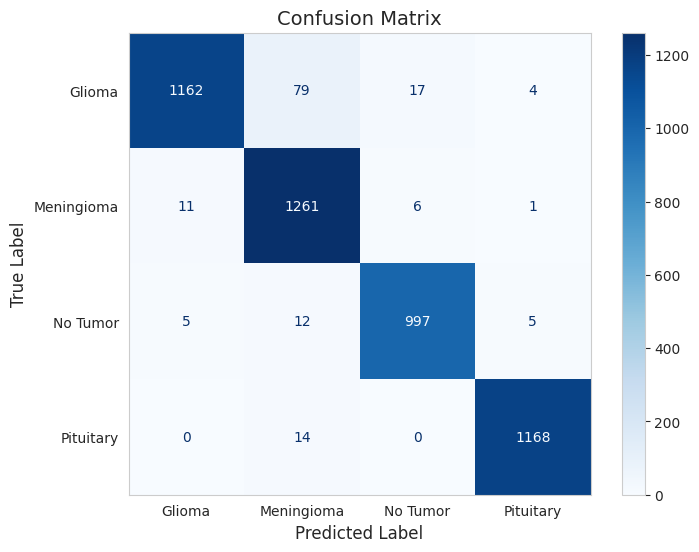

--------------------------------------------------------------------------------


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# ✅ Generate Predictions
y_pred_probs = model.predict(test_images)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class predictions

# ✅ Classification Report
report = classification_report(test_labels, y_pred, target_names=["Glioma", "Meningioma", "No Tumor", "Pituitary"])
print("📌 Classification Report:\n")
print(report)
print("-" * 80)  # Horizontal Rule

# ✅ Accuracy Calculation
accuracy = accuracy_score(test_labels, y_pred)
print(f"✅ Model Accuracy: {accuracy * 100:.2f}%")
print("-" * 80)  # Horizontal Rule

# ✅ Confusion Matrix (Fixed orientation)
cm = confusion_matrix(test_labels, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Glioma", "Meningioma", "No Tumor", "Pituitary"])

disp.plot(cmap="Blues", ax=ax, values_format="d")  # Use integer format for clarity
ax.set_title("Confusion Matrix", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=12)
ax.set_ylabel("True Label", fontsize=12)
plt.grid(False)  # Remove background grid
plt.show()

print("-" * 80)  # Horizontal Rule


✅ Best Trial: 04
🏆 Best Validation Accuracy: 96.75%

📌 Best Hyperparameters:
  - layer_0_filters: 32
  - Conv layers: 3
  - layer_1_filters: 128
  - Dropout rate: 0.5
  - Dense layer: 128
  - layer_2_filters: 32


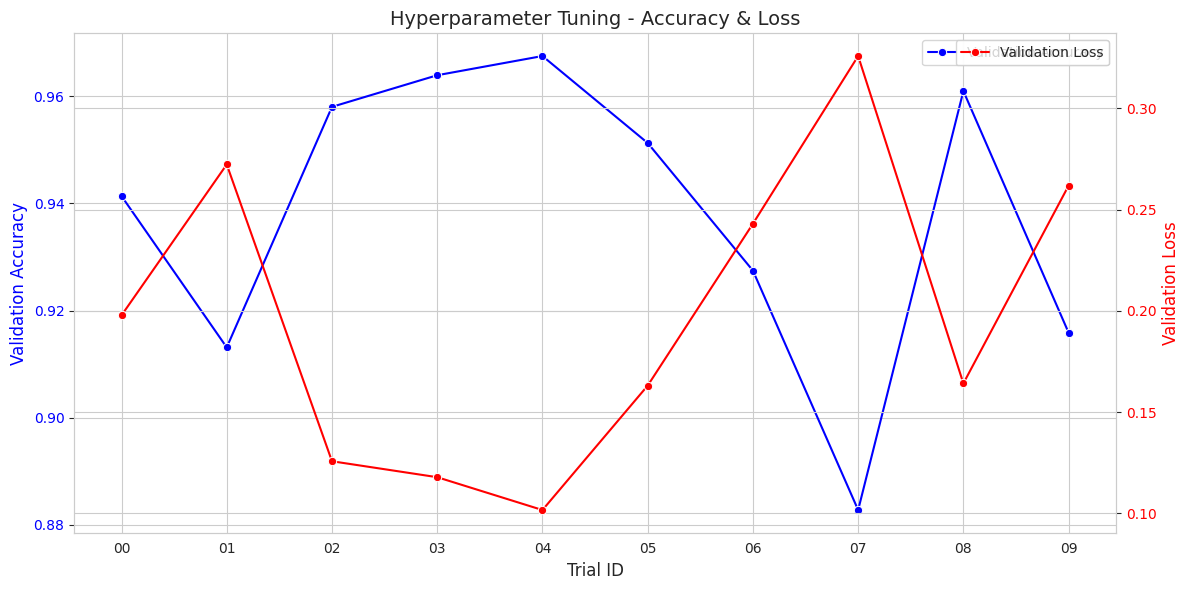

In [36]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# ✅ Define tuner directory path
tuner_dir = "/content/hyperparameter_tuning/untitled_project"

# ✅ Extract trial paths
trial_dirs = sorted(glob.glob(os.path.join(tuner_dir, "trial_*")))

trial_ids = []
val_accuracies = []
val_losses = []
hyperparams = {}

# ✅ Extract trial data
for trial_path in trial_dirs:
    trial_json_path = os.path.join(trial_path, "trial.json")

    if not os.path.exists(trial_json_path):
        continue

    # ✅ Load trial results
    with open(trial_json_path, "r") as f:
        trial_data = json.load(f)

    # ✅ Extract trial ID
    trial_id = trial_data.get("trial_id", trial_path.split("_")[-1])
    trial_ids.append(trial_id)

    # ✅ Extract validation accuracy & loss, ensuring they are floats
    try:
        val_acc = float(trial_data["metrics"]["metrics"]["val_accuracy"]["observations"][0]["value"][0])
        val_loss = float(trial_data["metrics"]["metrics"]["val_loss"]["observations"][0]["value"][0])
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)
    except (KeyError, ValueError, IndexError) as e:
        print(f"⚠️ Skipping trial {trial_id} due to missing or invalid data: {e}")

    # ✅ Extract best hyperparameters
    if "hyperparameters" in trial_data:
        hyperparams[trial_id] = trial_data["hyperparameters"]["values"]

# ✅ Find the best trial based on max validation accuracy
if val_accuracies:
    best_trial_idx = np.argmax(val_accuracies)
    best_trial_id = trial_ids[best_trial_idx]
    best_hyperparams = hyperparams.get(best_trial_id, {})

    # ✅ Print best trial results in a clean format
    print("\n" + "="*50)
    print(f"✅ Best Trial: {best_trial_id}")
    print(f"🏆 Best Validation Accuracy: {val_accuracies[best_trial_idx] * 100:.2f}%")
    print("\n📌 Best Hyperparameters:")
    for key, value in best_hyperparams.items():
        print(f"  - {key}: {value}")
    print("="*50)

# ✅ Plot Accuracy & Loss in a Single Graph
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(12, 6))

# ✅ Plot Accuracy (Left Y-Axis)
ax1.set_xlabel("Trial ID", fontsize=12)
ax1.set_ylabel("Validation Accuracy", color="blue", fontsize=12)
sns.lineplot(x=trial_ids, y=val_accuracies, marker="o", color="blue", ax=ax1, label="Validation Accuracy")
ax1.tick_params(axis='y', labelcolor="blue")

# ✅ Create second Y-Axis for Loss
ax2 = ax1.twinx()
ax2.set_ylabel("Validation Loss", color="red", fontsize=12)
sns.lineplot(x=trial_ids, y=val_losses, marker="o", color="red", ax=ax2, label="Validation Loss")
ax2.tick_params(axis='y', labelcolor="red")

# ✅ Title and layout
plt.title("Hyperparameter Tuning - Accuracy & Loss", fontsize=14)
fig.tight_layout()

plt.show()